# Install dependencies

In [1]:
import sys
!{sys.executable} -m pip install pillow matplotlib scikit-image scikit-learn

     |████████████████████████████████| 35.8 MB 14.2 MB/s eta 0:00:01   |████▉                           | 5.5 MB 4.5 MB/s eta 0:00:07     |█████████                       | 10.1 MB 4.5 MB/s eta 0:00:06
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
     |████████████████████████████████| 3.3 MB 12.3 MB/s eta 0:00:01     |███▉                            | 399 kB 12.3 MB/s eta 0:00:01
  Using cached tifffile-2021.11.2-py3-none-any.whl (178 kB)
     |████████████████████████████████| 4.3 MB 15.3 MB/s eta 0:00:01     |████████████████████████████▊   | 3.9 MB 15.3 MB/s eta 0:00:01


# Load libraries & define paths

In [1]:
import numpy as np
from skimage.io import imsave, imread
from skimage.segmentation import slic
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import cv2 as cv # need to execute "pip install opencv-python" in the terminal to install module
import numpy as np
import os
import rasterio
from skimage import exposure, filters

In [2]:
# this is the path to the images from your current folder. To adapt
INPUT_DIR = "data/"

# View some images

In [4]:
EXAMPLE_PATH1 = INPUT_DIR + 'EO_Browser_images-2018_0407/B02.tiff'
EXAMPLE_PATH2 = INPUT_DIR + 'EO_Browser_images-2018_0407/True_color.tiff'
EXAMPLE_PATH3 = INPUT_DIR + 'EO_Browser_images-2018_0407/SWIR.tiff'

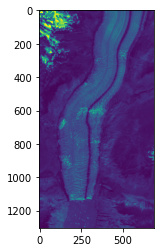

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


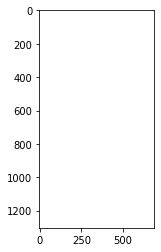

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


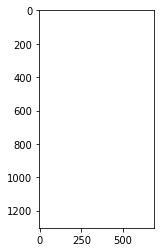

In [5]:
raster1 = rasterio.open(EXAMPLE_PATH1)
array1 = raster1.read()
array1 = array1.transpose(1, 2, 0)

plt.figure()
plt.imshow(array1)
plt.show()

raster2 = rasterio.open(EXAMPLE_PATH2)
array2 = raster2.read()
array2 = array2.transpose(1, 2, 0)

plt.figure()
plt.imshow(array2)
plt.show()

raster3 = rasterio.open(EXAMPLE_PATH3)
array3 = raster3.read()
array3 = array3.transpose(1, 2, 0)

plt.figure()
plt.imshow(array3)
plt.show()

# 0. Normalising the images with opencv
Since some images' values are out of range, we need to normalise.

Normalisation of 
- bands 2, 3, 4, 8A, 11, 12 (should change nothing visually)
- SWIR image
- true color image

In [6]:
def get_normalized_image(image, percentiles=(2, 98)):
    """
    Rescale image to values between 0 to 255 (capping outlier values) 
    
    Parameters
    ==================
    image: Numpy array
        Image numpy array with shape (height, width, num_bands)
    
    percentiles: tuple
        Tuple of min and max percentiles to cap outlier values
    
    Returns
    ==================
    output: Numpy array
        Normalized image numpy array
    
    """
    output = np.zeros_like(image)
    for k in range(image.shape[2]): # for each band
        p_min, p_max = np.percentile(image[:, :, k], percentiles)
        output[:, :, k] = exposure.rescale_intensity(image[:, :, k], 
                            in_range=(p_min, p_max), out_range=(0, 255))
    return output.astype(np.uint8)

In [7]:
to_norm = ['B02', 'B03', 'B04', 'B8A', 'B11', 'B12', 'SWIR', 'True_color']

In [8]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file 
        print(CURRENT_PATH)
        for img in to_norm:
            input_path = CURRENT_PATH + '/' + img + '.tiff'
            # Open raster and save into numpy array
            raster = rasterio.open(input_path)
            array = raster.read()
            # Reshpae to get height x width x bands
            array = array.transpose(1, 2, 0)
            # Normalise the image by calling function
            norm_img = get_normalized_image(array, percentiles=(2, 98))
            output_path = CURRENT_PATH + '/' + img + '_norm.tiff'
            imsave(output_path, norm_img)
            print(img + ' has been normalised')

data/EO_Browser_images-2020_2110
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2018_0407
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2019_0308
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2020_0609
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2019_2210
B02 has been normalised
B03 has bee

### Visualise some images

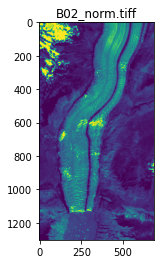

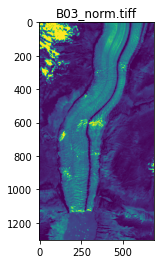

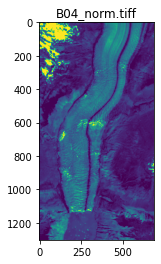

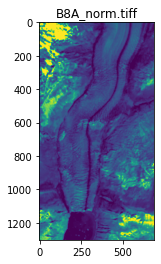

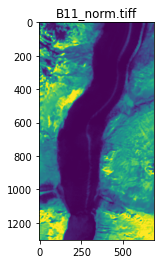

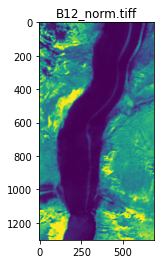

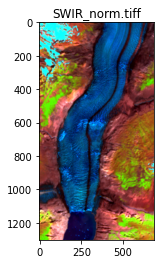

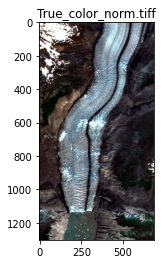

In [11]:
normed_imgs = ['B02_norm.tiff', 'B03_norm.tiff', 'B04_norm.tiff', 'B8A_norm.tiff', 'B11_norm.tiff', 'B12_norm.tiff', 'SWIR_norm.tiff', 'True_color_norm.tiff']

for img in normed_imgs:
    NEW_PATH = INPUT_DIR + 'EO_Browser_images-2018_0407/' + img #path to a picture
    img_read = imread(NEW_PATH, plugin='pil') # call PIL to read the file corectly

    plt.figure()
    plt.title(img)
    plt.imshow(img_read)
    plt.show()

# 1. Create new spectral indices (features)

## NDSI
NDSI =  (B3 - B11)/(B3 + B11)

In [12]:
def NDSI(input_B3, input_B11, output_path):
    """
    Input: path to B3 band .tif and B11 .tif
    ===========
    Output: NDSI.tif
    """
    
    B3 = imread(input_B3, plugin='pil').astype(np.float32)
    B11 = imread(input_B11, plugin='pil').astype(np.float32)
    ndsi = np.zeros_like(B3)
    ndsi = (B3 - B11)/(B3 + B11)
    imsave(output_path, ndsi)

In [14]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file 
        print(CURRENT_PATH)
        # Find B3 and B11 .tiff files
        input_B3 = CURRENT_PATH + '/B03.tiff'
        input_B11 = CURRENT_PATH + '/B11.tiff'
        # Calculate NDSI and save by calling function
        output_path = CURRENT_PATH + '/NDSI.tiff'
        ndsi = NDSI(input_B3, input_B11, output_path)
        print('NDSI has been calculated')

data/EO_Browser_images-2020_2110
NDSI has been calculated
data/EO_Browser_images-2018_0407
NDSI has been calculated
data/EO_Browser_images-2019_0308
NDSI has been calculated
data/EO_Browser_images-2020_0609
NDSI has been calculated
data/EO_Browser_images-2019_2210
NDSI has been calculated
data/EO_Browser_images-2018_2907
NDSI has been calculated


### View NDSI

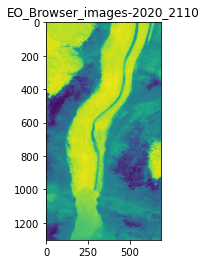

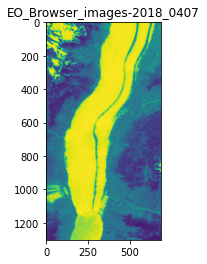

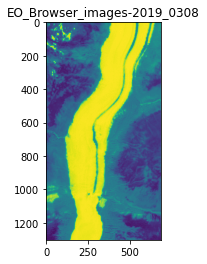

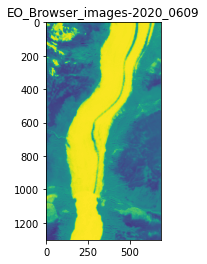

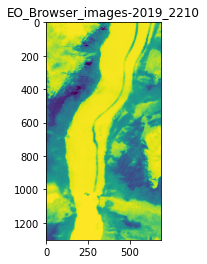

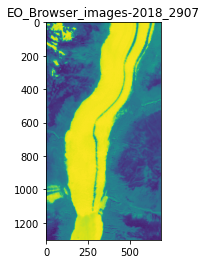

In [17]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file + '/NDSI.tiff'
        
        raster = rasterio.open(CURRENT_PATH)
        array = raster.read()
        array = array.transpose(1,2,0)

        plt.figure()
        plt.title(file)
        plt.imshow(array)
        plt.show()

## NDWI
NDWI = (B3 - B8)/(B3 + B8)

In [18]:
def NDWI(input_B3, input_B8, output_path):
    """
    Input: path to B3 band .tif and B8 .tif
    ===========
    Output: NDWI.tif
    """
    
    B3 = imread(input_B3, plugin='pil').astype(np.float32)
    B8 = imread(input_B8, plugin='pil').astype(np.float32)
    ndsi = np.zeros_like(B3)
    ndwi = (B3 - B8)/(B3 + B8)
    imsave(output_path, ndwi)

In [20]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file 
        print(CURRENT_PATH)
        # Find B3 and B11 .tiff files
        input_B3 = CURRENT_PATH + '/B03.tiff'
        input_B8 = CURRENT_PATH + '/B08.tiff'
        # Calculate NDSI and save by calling function
        output_path = CURRENT_PATH + '/NDWI.tiff'
        ndwi = NDWI(input_B3, input_B8, output_path)
        print('NDWI has been calculated')

data/EO_Browser_images-2020_2110
NDWI has been calculated
data/EO_Browser_images-2018_0407
NDWI has been calculated
data/EO_Browser_images-2019_0308
NDWI has been calculated
data/EO_Browser_images-2020_0609
NDWI has been calculated
data/EO_Browser_images-2019_2210
NDWI has been calculated
data/EO_Browser_images-2018_2907
NDWI has been calculated


### View NDWI

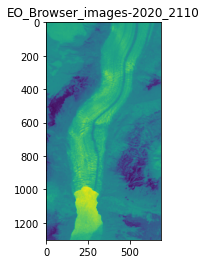

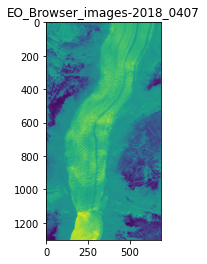

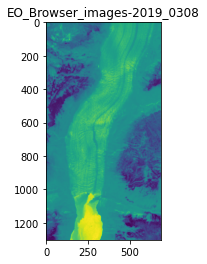

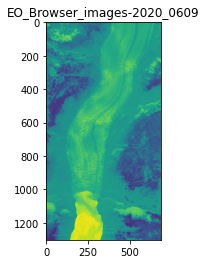

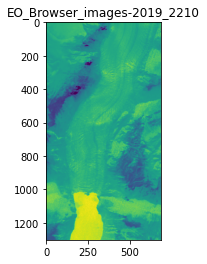

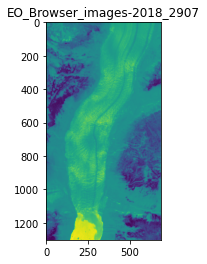

In [21]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file + '/NDWI.tiff'
        
        raster = rasterio.open(CURRENT_PATH)
        array = raster.read()
        array = array.transpose(1,2,0)

        plt.figure()
        plt.title(file)
        plt.imshow(array)
        plt.show()

# 2. Calculate morphologic features (with filters)
https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#module-skimage.filters.rank

https://scikit-image.org/docs/stable/api/skimage.filters.html


- Sobel: finds edges (test which one is better)
- Sobel_h: horizontal edges (?)
- Sobel_v: vertical edges (?)
- Difference of gaussians: Find features between low_sigma and high_sigma in size
- Entropy
- Gradient

To test:
- Rank order
- Threshold in function of index (see literature)
- Autolevel
- rank majority to test
- local sum

In [47]:
def apply_filters(img, list_filters, path):
    """
    Input: list of filters to appy (use skimage names)
    ===========
    Output: Create new .tiffs
    """
    
    for i in range(len(list_filters)):
        new_path = path
        curr_filter = list_filters[i]
        name = curr_filter.__name__
        print(name)
        new_path = new_path + '/' + name + '.tiff'
        print(new_path)
        
        # Depending if function needs extra parameters
        if name == 'entropy':
            footprint = square(5)
            filtered_img = curr_filter(img, selem=footprint)
        else:
            filtered_img = curr_filter(img)
            
        imsave(new_path, filtered_img.astype(np.float32))

In [49]:
### DOESNT WORK YET: PROBLEM SAVING THE OUTPUT

from skimage.morphology import square

# Example: to change list
list_test = [filters.sobel, filters.gaussian, filters.rank.entropy threshold] # TO ADAPT

for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file
        # Find True_color.tiff files
        input_img = CURRENT_PATH + '/True_color.tiff' # TO CHECK: on what img do we apply the filter?
        # Apply filters and save them 
        apply_filters(img, list_test, CURRENT_PATH)
        print('Filters have been applied')

sobel
data/EO_Browser_images-2020_2110/sobel.tiff
gaussian
data/EO_Browser_images-2020_2110/gaussian.tiff
entropy
data/EO_Browser_images-2020_2110/entropy.tiff
Filters have been applied
sobel
data/EO_Browser_images-2018_0407/sobel.tiff
gaussian
data/EO_Browser_images-2018_0407/gaussian.tiff
entropy
data/EO_Browser_images-2018_0407/entropy.tiff
Filters have been applied
sobel
data/EO_Browser_images-2019_0308/sobel.tiff
gaussian
data/EO_Browser_images-2019_0308/gaussian.tiff
entropy
data/EO_Browser_images-2019_0308/entropy.tiff
Filters have been applied
sobel
data/EO_Browser_images-2020_0609/sobel.tiff
gaussian
data/EO_Browser_images-2020_0609/gaussian.tiff
entropy
data/EO_Browser_images-2020_0609/entropy.tiff
Filters have been applied
sobel
data/EO_Browser_images-2019_2210/sobel.tiff
gaussian
data/EO_Browser_images-2019_2210/gaussian.tiff
entropy
data/EO_Browser_images-2019_2210/entropy.tiff
Filters have been applied
sobel
data/EO_Browser_images-2018_2907/sobel.tiff
gaussian
data/EO_Bro

### Visualise filters

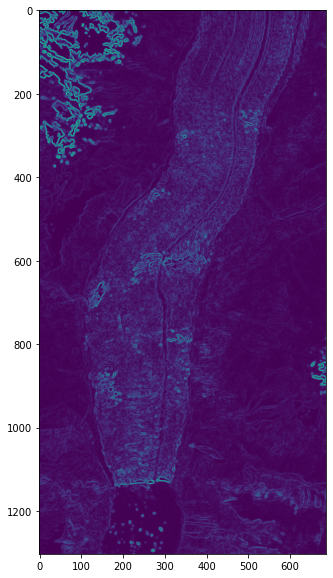

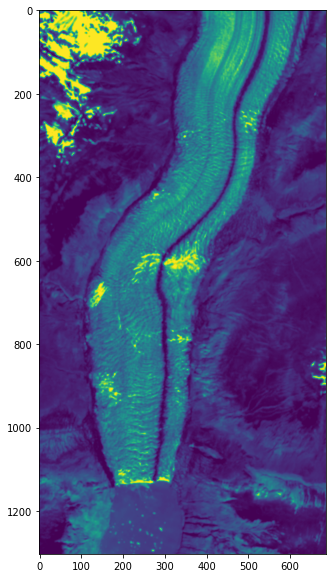

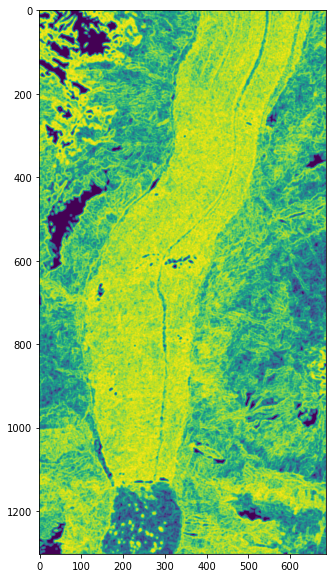

In [51]:
SOBEL = INPUT_DIR + 'EO_Browser_images-2018_0407/sobel.tiff'
GAUSS = INPUT_DIR + 'EO_Browser_images-2018_0407/gaussian.tiff'
ENTROPY = INPUT_DIR + 'EO_Browser_images-2018_0407/entropy.tiff'

img_sobel = imread(SOBEL, plugin='pil')
img_gauss = imread(GAUSS, plugin='pil')
img_entr = imread(ENTROPY, plugin='pil')

"""
# Test to apply a filter
test = filters.sobel(img)
test = test.astype(np.float32)
"""

plt.figure(figsize=(10,10))
plt.imshow(img_sobel)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(img_gauss)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(img_entr)
plt.show()

# 3. Create train/val/test sets

### Split dataset into train/validation/test

In [94]:
# Defining which images will belong to the train, test, and validation sets
train_dates = ['2018_0407', '2018_2907', '2019_0308', '2019_2210', '2020_0609', '2020_2110'] 
#test_idx = [...]
#validation_idx = [..]
feature_list = ['B02.tiff', 'True_color.tiff', 'gaussian.tiff'] # TO ADAPT

all_train_features = []
all_train_gt = []

for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file
        year = file.split("EO_Browser_images-", 1)[1].split("_", 1)[0]
        date = file.split("EO_Browser_images-", 1)[1]
        # Initialise a list of features for a certain year
        features_of_year = []
        if date in train_dates:
            print(date)
            for feature in feature_list:
                PATH_FEATURE = CURRENT_PATH = INPUT_DIR + file + "/" + feature
                
                # Open image and add it to the current year's list of features
                feat_img = imread(PATH_FEATURE, plugin='pil')
                features_of_year.append(feat_img) 

            # Find ground truth for that year
            GT_PATH = INPUT_DIR + 'gt/GT_marker_' + date + '.tif'
            gt_img = imread(GT_PATH, plugin='pil')
            
            all_train_features.append(features_of_year)
            all_train_gt.append(gt_img)
            
            print("Added features and ground truth for that date")
            
"""
# Tranforming the list all_train_features in an array of shape: (num_all_regions)
train_features = np.concatenate(all_train_features)
print("train_features shape " + str(train_features.shape))
# Tranforming the list all_train_region_features in an array of shape: (num_all_regions, num_features)
train_gt = np.concatenate(all_train_gt)
print("train_gt shape " + str(train_gt.shape))
"""

2020_2110
Added features and ground truth for that date
2018_0407
Added features and ground truth for that date
2019_0308
Added features and ground truth for that date
2020_0609
Added features and ground truth for that date
2019_2210
Added features and ground truth for that date
2018_2907
Added features and ground truth for that date


'\n# Tranforming the list all_train_features in an array of shape: (num_all_regions)\ntrain_features = np.concatenate(all_train_features)\nprint("train_features shape " + str(train_features.shape))\n# Tranforming the list all_train_region_features in an array of shape: (num_all_regions, num_features)\ntrain_gt = np.concatenate(all_train_gt)\nprint("train_gt shape " + str(train_gt.shape))\n'

In [95]:
all_train_features

[[array([[27007, 27512, 27571, ...,  7550,  7464,  7222],
         [26529, 27171, 27800, ...,  7353,  7229,  7012],
         [26378, 27007, 28128, ...,  7038,  6973,  6960],
         ...,
         [ 5629,  5911,  6108, ...,  4889,  5256,  5924],
         [ 6173,  6514,  6665, ...,  5230,  5695,  6390],
         [ 6776,  7065,  7097, ...,  5695,  6285,  6973]], dtype=uint16),
  array([[[193, 221, 237],
          [195, 225, 237],
          [199, 230, 238],
          ...,
          [ 74,  76,  73],
          [ 72,  74,  72],
          [ 70,  69,  70]],
  
         [[191, 219, 237],
          [193, 224, 237],
          [199, 230, 238],
          ...,
          [ 72,  74,  71],
          [ 70,  71,  70],
          [ 68,  66,  68]],
  
         [[191, 221, 237],
          [193, 225, 237],
          [198, 230, 238],
          ...,
          [ 69,  71,  68],
          [ 68,  68,  68],
          [ 67,  65,  67]],
  
         ...,
  
         [[ 63,  59,  54],
          [ 66,  62,  57],
        

In [98]:
all_train_gt

[array([[[137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         ...,
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255]],
 
        [[137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         ...,
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255]],
 
        [[137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         ...,
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255]],
 
        ...,
 
        [[137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         ...,
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255]],
 
        [[137,  71,  28, 255],
         [137,  71,  28, 255],
         [137,  71,  28, 255],
         ...,
         [137,  71,  28, 255],
         [137,  71,  28, 255],
    

# 4. Train a Random Forest classifier

In [99]:
classifier = RandomForestClassifier(random_state=10)
classifier.fit(all_train_features, all_train_gt)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (6, 3, 1303, 687) + inhomogeneous part.

# 5. Function to prediction classification

In [ ]:
def predict_classification_maps_and_get_accuracy(classifier, image_numbers, input_dir, save_predictions=False):
    list_predictions = []
    list_gt_labels = []
    for image_number in image_numbers:
        # Read segmented image
        segmented_image_path = INPUT_DIR + "regions/" + ...
        segmented_image = imread(segmented_image_path)
        # Read features using the function: np.load(file_path.npy)
        region_features_path = INPUT_DIR + "features/" + ...
        region_features = np.load(region_features_path)
        # Normalize features by substracting the mean and dividing by the standard deviation (of the train set) 
        norm_region_features = (region_features - mean_per_feature) / std_per_feature
        # Predict label of regions 
        label_predictions = classifier.predict(norm_region_features)
        # Compute label predictions per pixel
        predicion_map = np.zeros(segmented_image.shape).astype(np.uint8)
        num_regions = len(np.unique(segmented_image))
        for region_id in range(num_regions):
            # Set the label predicted for a region to all the pixels of that region
            predicion_map[segmented_image==region_id] = label_predictions[region_id]
        
        list_predictions.append(predicion_map.flatten())
        
        if save_predictions:
            # Save prediction map image
            prediction_map_path = INPUT_DIR + "prediction_map_" + ...
            imsave(prediction_map_path, predicion_map)
        
        # Get ground truth label
        gt_path = INPUT_DIR + "gt/" + ...
        gt = imread(gt_path)
        
        list_gt_labels.append(gt.flatten())
    
    all_predictions = np.concatenate(list_predictions)
    all_gt_labels = np.concatenate(list_gt_labels)
    accuracy = accuracy_score(all_gt_labels, all_predictions)
    conf_matrix = confusion_matrix(all_gt_labels, all_predictions)
                     
    return accuracy, conf_matrix


def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

# 6. Compute performance on validation set

In [ ]:
acc_val, conf_matrix_val = predict_classification_maps_and_get_accuracy(classifier, validation_image_numbers, input_dir)
print(acc_val)
print(conf_matrix_val)

In [ ]:
plot_confusion_matrix(conf_matrix_val)

# 7. Hyperparameter tuning

In [ ]:
# List of paramaters to evaluate in the validation set
n_estimators_values = [20, 50, 100, 200]
max_depth_values = [5, 10, 20, None]

In [ ]:
# Initialise best_val_accuracy, best_depth and best_n_estimators
best_val_accuracy = -1
best_depth = None
best_n_estimators = None

for n_estimators_val in n_estimators_values:
    for max_depth_val in max_depth_values:
        print("eval n_estimators_val {} max_depth_val {}".format(n_estimators_val, max_depth_val))
        classifier = RandomForestClassifier(random_state=10, n_estimators=n_estimators_val, max_depth=max_depth_val)
        classifier.fit(norm_train_features, train_labels)
        val_acc, conf_matrix_val = predict_classification_maps_and_get_accuracy(classifier, validation_image_numbers, input_dir)
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_depth = max_depth_val
            best_n_estimators = n_estimators_val
            print(val_acc)
            
print("Best max depth: " +str(best_depth))
print("Best number estimators: "+str(best_n_estimators))        

# 8. Train final model & predict on test set

In [ ]:
classifier = RandomForestClassifier(random_state=10, n_estimators=best_n_estimators, max_depth=best_depth)
classifier.fit(norm_train_features, train_labels)
accuracy, conf_matrix = predict_classification_maps_and_get_accuracy(classifier, test_image_numbers, input_dir, save_predictions=True)

In [ ]:
best_acc_test, best_conf_matrix_test = predict_classification_maps_and_get_accuracy(classifier, test_image_numbers, input_dir, save_predictions=True)
print(best_acc_test)
print(best_conf_matrix_test)

# 9. View results --> modify function

In [ ]:
import matplotlib.pyplot as plt

def display_label_image(label_map):
    colors = np.array([[255, 255, 255], # Impervious: white
                       [0, 0, 255],     # Building: Blue
                       [0, 255, 255],   # Low vegetation: cyan
                       [0, 255, 0]])    # Tree: green
    colors = colors.astype(np.uint8)
    color_map = np.zeros((label_map.shape[0], label_map.shape[1], 3)).astype(np.uint8)
    for label_id in range(colors.shape[0]):
        color_map[label_map == label_id] = colors[label_id, :]
    plt.figure(figsize = (11,11)) 
    plt.imshow(color_map)

In [ ]:
prediction_map_path = input_dir + "prediction_map_" +str(4) + ".tif" #need to change image number and select one of the saved ones
prediction_map = imread(prediction_map_path)
display_label_image(prediction_map)

# 10. Compute ice melting